In [1]:
!pip install matplotlib networkx

In [2]:
import matplotlib.pyplot as plt
import networkx as nx #python package for networks
import numpy as np
import random

In [3]:
# Creates location object and bidirectional connection between locations
class Location:
    def __init__(self, name):
        self.name = name
        self.connections = []

    def connect(self, otherLocation):
        self.connections.append(otherLocation)
        otherLocation.connections.append(self)

In [4]:
# Creates World Map using networkx and matplotlib
class GameMap:
    def __init__(self):
        self.locations = {}
        self.graph = nx.Graph()

    # Adds location to location dictionary and node to networkX
    def addLocation(self, name):
        location = Location(name)
        self.locations[name] = location
        self.graph.add_node(name)

    # Adds edges between connecting locations
    def connectLocations(self, name1, name2):
        if name1 in self.locations and name2 in self.locations:
            loc1 = self.locations[name1]
            loc2 = self.locations[name2]
            loc1.connect(loc2)
            self.graph.add_edge(name1, name2)

    # Sets up node locations on matplotlib with networkX graph
    def drawMap(self, currentLocation=None):
        pos = {
            "Village": (0.5, 0),
            "Quests": (-0.5, 0.75),
            "Blacksmith": (-0.5, -0.75),
            "Apothecary": (-0.5, -0.25),
            "Dungeon": (1.5, 0)
        }

        # Plots matplotlib with size
        plt.figure(figsize=(6, 5))

        # Draws edges as connections
        nx.draw_networkx_edges(self.graph, pos)

        # Draws nodes as locations
        nx.draw_networkx_nodes(self.graph, pos,
                                 node_size=1700,
                                 node_color='lightgreen')
        # Draws location labels
        nx.draw_networkx_labels(self.graph, pos,
                                  font_size=10)

        # Marks current player location as orange
        if currentLocation and currentLocation in self.graph:
            nx.draw_networkx_nodes(self.graph, pos,
                                    nodelist=[currentLocation],
                                    node_color='orange', node_size=1700)

        # Plots World Map
        plt.title("World Map")
        plt.axis('off')
        plt.pause(0.001)

In [5]:
# Creates Dungeon Map as rows x cols grid map using matplotlib

class DungeonMap:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.grid = self.generate()
        self.playerPos = self.Start()
        self.startPos = self.Start()
        self.exitPos = self.Exit()
        self.visited = set([self.playerPos])

    # Generates tiles
    def generate(self):
        grid = [['wall' for _ in range(self.cols)] for _ in range(self.rows)]

        current = (1, 1)

        # Labels initial tile R1
        grid[current[0]][current[1]] = 'R1'
        # Places room into stack
        stack = [current]
        roomCount = 1

        while stack:
            current = stack.pop()
            neighbors = [(current[0]+x, current[1]+y) for x, y in [(0,1),(1,0),(0,-1),(-1,0)]]
            random.shuffle(neighbors)
            for nextTile in neighbors:
                if (0 <= nextTile[0] < self.rows and 0 <= nextTile[1] < self.cols
                    and grid[nextTile[0]][nextTile[1]] == 'wall'):
                    grid[nextTile[0]][nextTile[1]] = f'R{roomCount+1}'
                    stack.append(nextTile)
                    roomCount += 1
                    break

        return grid

    # Sets starting tile at R1
    def Start(self):
        for i in range(self.rows):
            for j in range(self.cols):
                if self.grid[i][j] == 'R1':
                    return (i, j)
        return (0, 0)

    # Sets exit tile randomly at a valid tile that is not the start tile
    def Exit(self):
        valid = [(i, j) for i in range(self.rows) for j in range(self.cols)
                           if self.grid[i][j].startswith('R') and (i, j) != self.playerPos]
        exitPos = random.choice(valid)
        self.grid[exitPos[0]][exitPos[1]] = 'EXIT'
        return exitPos

    # Draws map with matplot lib as a 2D grid
    def drawMap(self):
        fig, ax = plt.subplots(figsize=(5, 5))

        # Sets colors of tiles depending on their descriptions
        for x in range(self.cols):
            for y in range(self.rows):
                if self.grid[y][x] == 'wall':
                    color = 'black'
                elif self.grid[y][x] == 'EXIT':
                    color = 'green'
                elif (y, x) in self.visited:
                    color = 'lightblue'
                else:
                    color = 'white'
                rect = plt.Rectangle((x, y), 1, 1, edgecolor='black', facecolor=color)
                ax.add_patch(rect)
                if self.grid[y][x].startswith('R') or self.grid[y][x] == 'EXIT':
                    ax.text(x+0.5, y+0.5, self.grid[y][x], ha='center', va='center')

        # Creates player as a red circle on the grid
        player = plt.Circle((self.playerPos[1] + 0.5, self.playerPos[0] + 0.5), 0.3, color='red')
        ax.add_artist(player)

        ax.set_xlim(0, self.cols)
        ax.set_ylim(0, self.rows)
        ax.set_aspect('equal')
        ax.invert_yaxis()

        # Plots Dungeon Map
        plt.title("Dungeon Map")
        plt.axis('off')
        plt.pause(0.001)

    # Moves player either (up, down, left, right) depending on user input
    def movePlayer(self, direction):
        x, y = self.playerPos
        newPos = {
            'up': (x - 1, y),
            'down': (x + 1, y),
            'left': (x, y - 1),
            'right': (x, y + 1)
        }.get(direction, (x, y))

        # Updates new player position and marks as a visited node
        if (0 <= newPos[0] < self.rows and 0 <= newPos[1] < self.cols and
            (self.grid[newPos[0]][newPos[1]].startswith('R') or
             self.grid[newPos[0]][newPos[1]] == 'EXIT')):
            self.playerPos = newPos
            self.visited.add(newPos)
            return True
        return False

# Creates village with added location nodes and edges
def createVillage(gameMap):
    gameMap.addLocation("Village")
    gameMap.addLocation("Quests")
    gameMap.addLocation("Blacksmith")
    gameMap.addLocation("Apothecary")
    gameMap.addLocation("Dungeon")

    gameMap.connectLocations("Village", "Quests")
    gameMap.connectLocations("Village", "Blacksmith")
    gameMap.connectLocations("Village", "Apothecary")
    gameMap.connectLocations("Village", "Dungeon")

In [6]:
# Sets up Quests
class Quest:
  def processQuest():
    print("Welcome to the Quest Board")
    print("Select one of the following quests.")

    quest1 = "Find the mirror of enchantment."
    quest2 = "Defeat the vampire king."
    quest3 = "Discover the unexplored tomb."

    print(f"1. {quest1}")
    print(f"2. {quest2}")
    print(f"3. {quest3}")

In [7]:
# Sets up blacksmith
class Blacksmith:
  def processBlacksmith():
    print("Welcome to the Blacksmith")
    print("Select one of the following 1, 2 or exit.")
    print(f"1. weapons")
    print(f"2. armour")

  def processWeapon():
      print("Select one of the following weapons.")
      print(f"1. Bow")
      print(f"2. Daggers")
      print(f"3. Staff")
      print(f"4. Sword")

  def processArmour():
      print("Select one of the following armours.")
      print(f"1. Heavy Armour")
      print(f"2. Light Armour")
      print(f"3. Apprentice Robes")
      print(f"4. Master Robes")


In [8]:
# Sets up Apothecary
class Apothecary:
  def processApothecary():
    print("Welcome to the Apothecary")
    print("Select one of the following 1, 2 or exit.")
    print(f"1. Small Potion")
    print(f"2. Large Potion")


You are currently in: The Village


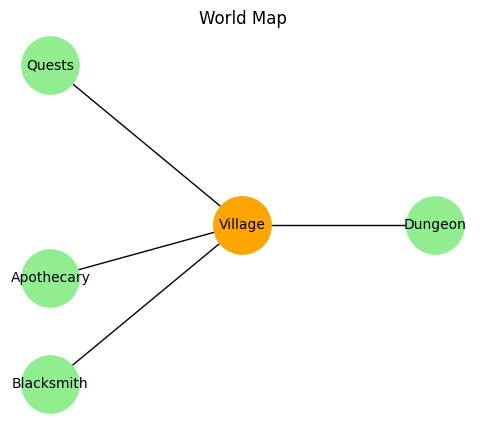

Where would you like to go?

You are currently in: The Quests
Welcome to the Quest Board
Select one of the following quests.
1. Find the mirror of enchantment.
2. Defeat the vampire king.
3. Discover the unexplored tomb.
Enter 1, 2, 3, or exit to return to village.
Quest Accepted

You are currently in: The Dungeon


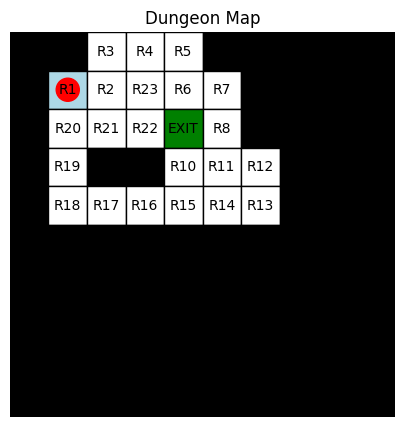

Dungeon Level: 1
Enter direction to move (up/down/left/right) or 'exit' to leave dungeon:
Invalid command. Please enter a valid direction or 'exit'.

You are currently in: The Dungeon


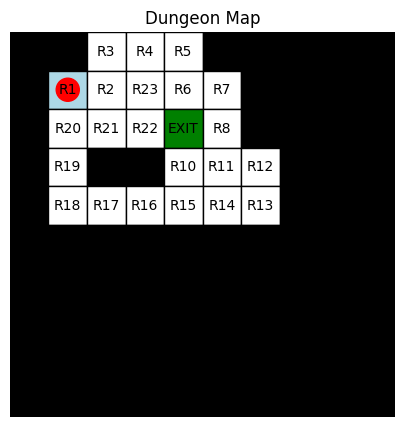

Dungeon Level: 1
Enter direction to move (up/down/left/right) or 'exit' to leave dungeon:

You are currently in: The Dungeon


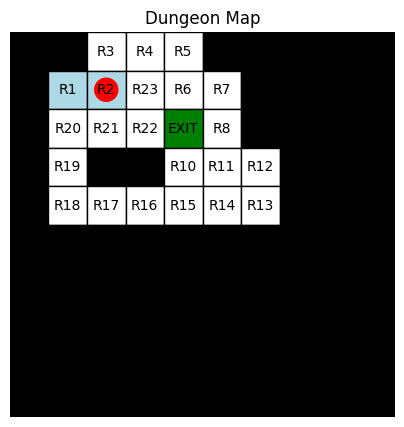

Dungeon Level: 1
Enter direction to move (up/down/left/right) or 'exit' to leave dungeon:

You are currently in: The Dungeon


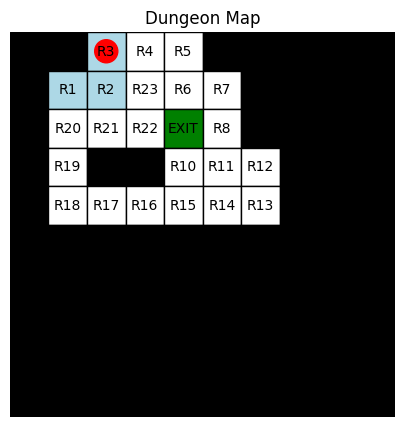

Dungeon Level: 1
Enter direction to move (up/down/left/right) or 'exit' to leave dungeon:


KeyboardInterrupt: Interrupted by user

In [9]:
def main():
    villageMap = GameMap()
    createVillage(villageMap)
    level1 = DungeonMap(10, 10)  # 10x10 grid for the dungeon
    level2 = None  # Initialize level2 and level3 as None
    level3 = None

    currentLocation = "Village"
    dungeonLevel = 1

    while True:
        print(f"\nYou are currently in: The {currentLocation}")

        # Current Location Dungeon
        if currentLocation == "Dungeon":
            if dungeonLevel == 1:
                level1.drawMap()
                print(f"Dungeon Level: {dungeonLevel}")
            elif dungeonLevel == 2:
                if level2 is None:  # Create level2
                    level2 = DungeonMap(10, 10)
                level2.drawMap()
                print(f"Dungeon Level: {dungeonLevel}")
            elif dungeonLevel == 3:
                if level3 is None:  # Create level3
                    level3 = DungeonMap(10, 10)
                level3.drawMap()
                print(f"Dungeon Level: {dungeonLevel}")

            print("Enter direction to move (up/down/left/right) or 'exit' to leave dungeon:")
            command = input().lower()

            if command in ['up', 'down', 'left', 'right']:
                if dungeonLevel == 1 and level1.movePlayer(command):
                    if level1.playerPos == level1.exitPos:
                        print("You found the exit! Moving to the next level.")
                        dungeonLevel += 1
                elif dungeonLevel == 2 and level2.movePlayer(command):
                    if level2.playerPos == level2.exitPos:
                        print("You found the exit! Moving to the next level.")
                        dungeonLevel += 1
                    elif level2.playerPos == level2.startPos:  # Move back to Level 1
                        print("Moving back to Level 1.")
                        dungeonLevel -= 1
                elif dungeonLevel == 3 and level3.movePlayer(command):
                    if level3.playerPos == level3.exitPos:
                        print("You finished your quest. Congratulations!")
                        # Clear current dungeon levels before returning to village
                        level1 = None
                        level2 = None
                        level3 = None
                        currentLocation = "Village"
                    elif level3.playerPos == level3.startPos:  # Move back to Level 2
                        print("Moving back to Level 2.")
                        dungeonLevel -= 1
                else:
                    print("Invalid move. Try again.")
            elif command == 'exit':
                currentLocation = "Village"
            else:
                print("Invalid command. Please enter a valid direction or 'exit'.")
        elif currentLocation == "Quests":
          Quest.processQuest()
          print(f"Enter 1, 2, 3, or exit to return to village.")
          command = input().lower()
          if command in ['1', '2', '3']:
            print("Quest Accepted")
            # TO DO LOGIC
            currentLocation = "Dungeon"
          elif command == 'exit':
            currentLocation = "Village"
          else:
            print("Invalid quest. Please choose a valid quest.")
        elif currentLocation == "Blacksmith":
          Blacksmith.processBlacksmith()
          choice = input().lower()
          if(choice == 'exit'):
            currentLocation = "Village"
          elif(choice == '1'):
            Blacksmith.processWeapon()
            choice = input().lower()
            if(choice == 'exit'):
              currentLocation = "Village"
          elif(choice == '2'):
            Blacksmith.processArmour()
            choice = input().lower()
            if(choice == 'exit'):
              currentLocation = "Village"
          else:
            print("Invalid choice. Please choose a valid option.")
        elif currentLocation == "Apothecary":
          Apothecary.processApothecary()
          print(f"Enter 1, 2, or exit to return to village.")
          command = input().lower()
          if command in ['1', '2']:
            print("Accepted")
          elif command == 'exit':
            currentLocation = "Village"
          else:
            print("Invalid quest. Please choose a valid quest.")
        else:
            villageMap.drawMap(currentLocation)
            print("Where would you like to go?")
            command = input().strip().capitalize()

            if command in villageMap.locations:
                currentLocation = command
            elif command.lower() == "exit":
                print("Exiting the game.")
                break
            else:
                print("Invalid location. Please choose a valid destination.")

        plt.close()  # Close the current plot before drawing the next one

if __name__ == "__main__":
    main()